# VaR

In [ ]:
!pip install pandas_datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import  pandas_datareader.data as web
import numpy as np
import yfinance as yf
import pandas as pd
import datetime as dt
from pandas_datareader import data as pdr
yf.pdr_override()

In [ ]:
# import data
def getData(stocks, start, end):
  stockData = web.get_data_yahoo(stocks,start=start,end=end)#.reset_index()
  stockData = stockData['Close']
  returns = stockData.pct_change()
  meanReturns = returns.mean()
  covMatrix = returns.cov() # Why calculate covariance matrix in the portfolio?
  return returns, meanReturns, covMatrix

#Portfolio Performance
def portfolioperfomance(weights, meanReturns, covMatrix, Time): #Time for time step to evaluate the VaR time step
  returns = np.sum(meanReturns*weights)*Time
  std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) )*np.sqrt(Time) # What is dot? To figure out this formula's meaning.
  return returns, std

Covariance is used in portfolio theory to determine what assets to include in the portfolio. Covariance is a statistical measure of the directional relationship between two asset prices. Modern portfolio theory uses this statistical measurement to reduce the overall risk for a portfolio. A positive covariance means that assets generally move in the same direction. Negative covariance means assets generally move in opposite directions.

Negative covariance => hedge risk

In [ ]:
stockList = ['AAPL','AMD','GOOG','INTC','NVDA'] #'TXN'
stocks = [stock for stock in stockList] #stock + '.AX' ?
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 800)

In [ ]:
returns, meanReturns, covMatrix = getData(stocks, start = startDate, end = endDate)
returns = returns.dropna()

[*********************100%***********************]  5 of 5 completed


In [ ]:
# random weights for portfolio
weights = np.random.random(len(returns.columns)) #weights will automatically update by the number of stocks, and this step just give a random number from 0 to 1 to each stock, they are not added to 100%
weights /= np.sum(weights) # To normalize weights to sum to 1

## Historical
Use historical data to calculate the portfolio performance.
weights, returns.

In [ ]:
# Then use weights to multiply each return to get the outcome for the day, historically.
returns['portfolio'] = returns.dot(weights)

In [ ]:
returns

,AAPL,AMD,GOOG,INTC,NVDA,portfolio
Date,,,,,,
2020-12-22,0.028465,-0.000751,-0.009124,-0.004098,-0.004050,0.002129
2020-12-23,-0.006976,-0.017282,0.005152,0.008664,-0.020259,-0.004783
2020-12-24,0.007712,0.002840,0.003735,0.010737,-0.001191,0.004209
2020-12-28,0.035766,-0.002287,0.021416,0.000000,-0.007215,0.015006
2020-12-29,-0.013315,-0.010699,-0.009780,0.049288,0.003353,-0.003409
...,...,...,...,...,...,...
2023-02-22,0.002896,-0.002084,-0.002716,-0.022640,0.004793,-0.001489
2023-02-23,0.003291,0.040987,-0.007952,0.005497,0.140214,0.029581
2023-02-24,-0.018005,-0.020815,-0.018887,-0.018352,-0.015974,-0.018287


Use the historical distributions to build VaR model.
The assumption of VaR model is the distribution is normal distribution.

In [ ]:
def historicalVaR(returns, alpha = 5): #alpha is confidence level, 5= 5%
   """
   Read in a pandas dataframe of returns / a pandas series of returns
   Output the percentile of the distribution st the given alpha confidence level
   """
   if isinstance(returns, pd.Series): # What is isinstance?
     return np.percentile(returns, alpha)
  
   #A passed user-defined-function will be passed a Series for evaluation
   elif isinstance(returns, pd.DataFrame):
     return returns.aggregate(historicalVaR, alpha=5) #Aggregate funtion?
  
   else:
     raise TypeError("Expected returns to be dataframe or series")

In [ ]:
print(historicalVaR(returns, alpha=5)) # for the pandas DataFrame, return all columns' loss percentile

AAPL        -0.033154
AMD         -0.053508
GOOG        -0.031939
INTC        -0.033820
NVDA        -0.056007
portfolio   -0.035472
dtype: float64


In [ ]:
print(historicalVaR(returns['portfolio'], alpha=5)) # Get the series's percentile

-0.03547181079099628


CVaR

In [ ]:
def historicalCVaR(returns, alpha = 5): #alpha is confidence level, 5= 5%
   """
   Read in a pandas dataframe of returns / a pandas series of returns
   Output the CVaR fro dataframe / series
   """
   if isinstance(returns, pd.Series):
     belowVaR = returns <= historicalVaR(returns, alpha =alpha)
     return returns[belowVaR].mean()
  
   #A passed user-defined-function will be passed a Series for evaluation
   elif isinstance(returns, pd.DataFrame):
     return returns.aggregate(historicalCVaR, alpha=5) #Aggregate funtion?
  
   else:
     raise TypeError("Expected returns to be dataframe or series")

In [ ]:
print(historicalCVaR(returns, alpha=5))

AAPL        -0.040451
AMD         -0.069571
GOOG        -0.045273
INTC        -0.053491
NVDA        -0.069854
portfolio   -0.044160
dtype: float64


In [ ]:
print(historicalCVaR(returns['portfolio'], alpha=5))

-0.04416017307267971


In [ ]:
# day
Time = 180

In [ ]:
VaR = -historicalVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
CVaR = -historicalCVaR(returns['portfolio'], alpha=5)*np.sqrt(Time) # Why is np.sqrt(Time)?
pRet, pStd = portfolioperfomance(weights, meanReturns, covMatrix, Time)

In [ ]:
#Lost measures
InitialInvestment = 100000
print('Expected Portfolio Return:       ', round(InitialInvestment*pRet, 2))
print('Value at Risk 95th CI:       ', round(InitialInvestment*VaR, 2))
print('Conditional VaR 95th CI:       ', round(InitialInvestment*CVaR, 2))

Expected Portfolio Return:        8569.52
Value at Risk 95th CI:        47590.43
Conditional VaR 95th CI:        59247.09


At 95th CI, we're happy that we are not going to lose any more than 42352.86 in 180 days historically with this portfolio.

In the 5th percentile, the lowest 5th percentile, the expected loss that we have (the expected shortfall) is 54741.09. 
The distribution to the downside, the downside is extremely skewed as it would be represented in the historical data. The CVaR gives the level of risk and what is the worst-case scenario and the expectation of that worst-case scenario.

## Parametric

In [ ]:
from scipy.stats import norm, t

In [ ]:
def var_parametric(portfolioReturn, portfolioStd, distribution = 'normal', alpha=5, dof=6): #degrees of freedom, what is this?
  """Calculate the portfolio VaR given a distribution, with known parameters"""
  if distribution == 'normal':
    VaR = norm.ppf(1-alpha/100)*portfolioStd - portfolioReturn  #What is ppf? this part is looking for returns at the right hand side of the distribution.
  
  elif distribution == 't-distribution':
    nu = dof
    VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu)*portfolioStd - portfolioReturn
  else:
    raise TypeError("Expected distribution to be 'normal' or 't-distribution'")
  
  return VaR

In [ ]:
def cvar_parametric(portfolioReturn, portfolioStd, distribution = 'normal', alpha=5, dof=6): #degrees of freedom, what is this?
  """Calculate the portfolio CVaR given a distribution, with known parameters"""
  if distribution == 'normal':
    CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portfolioReturn  #pdf: debsity function
  
  elif distribution == 't-distribution':
    nu = dof
    x_anu = t.ppf(alpha/100, nu)
    CVaR = -1/(alpha/100)* (1-nu)**-1 * (nu-2+x_anu**2) * t.pdf(x_anu, nu) *portfolioStd - portfolioReturn
  else:
    raise TypeError("Expected distribution to be 'normal' or 't-distribution'")
  
  return CVaR

In [ ]:
normVaR = var_parametric(pRet, pStd)
normCVaR = cvar_parametric(pRet, pStd)

In [ ]:
tVaR = var_parametric(pRet, pStd, distribution = 't-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution = 't-distribution')

In [ ]:
print('normal Value at Risk 95th CI:       ', round(InitialInvestment*normVaR, 2))
print('normal Conditional VaR 95th CI:       ', round(InitialInvestment*normCVaR, 2))

normal Value at Risk 95th CI:        38082.91
normal Conditional VaR 95th CI:        49934.5


In [ ]:
print('t-dist Value at Risk 95th CI:       ', round(InitialInvestment*tVaR, 2))
print('t-dist Conditional VaR 95th CI:       ', round(InitialInvestment*tCVaR, 2))

t-dist Value at Risk 95th CI:        36430.68
t-dist Conditional VaR 95th CI:        52585.08


t-distribution has a fat tail

## Monte Carlo Simulation
Computational simulations that rely on repeated random sampling to obtain results.

In the Monte Carlo Simulation, we increase the number of simulations and therefore how many samples we're taking from these underlying distributions.
We hope to try to converge on an exact solution.

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

In [ ]:
# import data
def get_data(stocks, start, end):
  stockData = pdr.get_data_yahoo(stocks,start=start,end=end)#.reset_index()
  stockData = stockData['Close']
  returns = stockData.pct_change()
  meanReturns = returns.mean()
  covMatrix = returns.cov()
  return meanReturns, covMatrix

In [ ]:
stockList = ['CBA','BHP','TLS','NAB','WBC', 'STO']
stocks = [stock + '.AX' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 300)

In [ ]:
meanReturns, covMatrix = get_data(stocks, startDate, endDate)

[*********************100%***********************]  6 of 6 completed


In [ ]:
meanReturns

BHP.AX   -0.000005
CBA.AX   -0.000024
NAB.AX   -0.000290
STO.AX   -0.000503
TLS.AX    0.000247
WBC.AX   -0.000223
dtype: float64

In [ ]:
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

In [ ]:
weights

array([0.2683008 , 0.20816734, 0.23309795, 0.03784185, 0.22004544,
       0.03254661])

Model

In [ ]:
#number of the simulations
mc_sims = 1000
T = 100 #timeframe in days

In [ ]:
meanM = np.full(shape = (T, len(weights)), fill_value = meanReturns)
meanM = meanM.T

In [ ]:
portfolio_sims = np.full(shape = (T, mc_sims), fill_value=0.0)

In [ ]:
InitialPortfolio = 10000

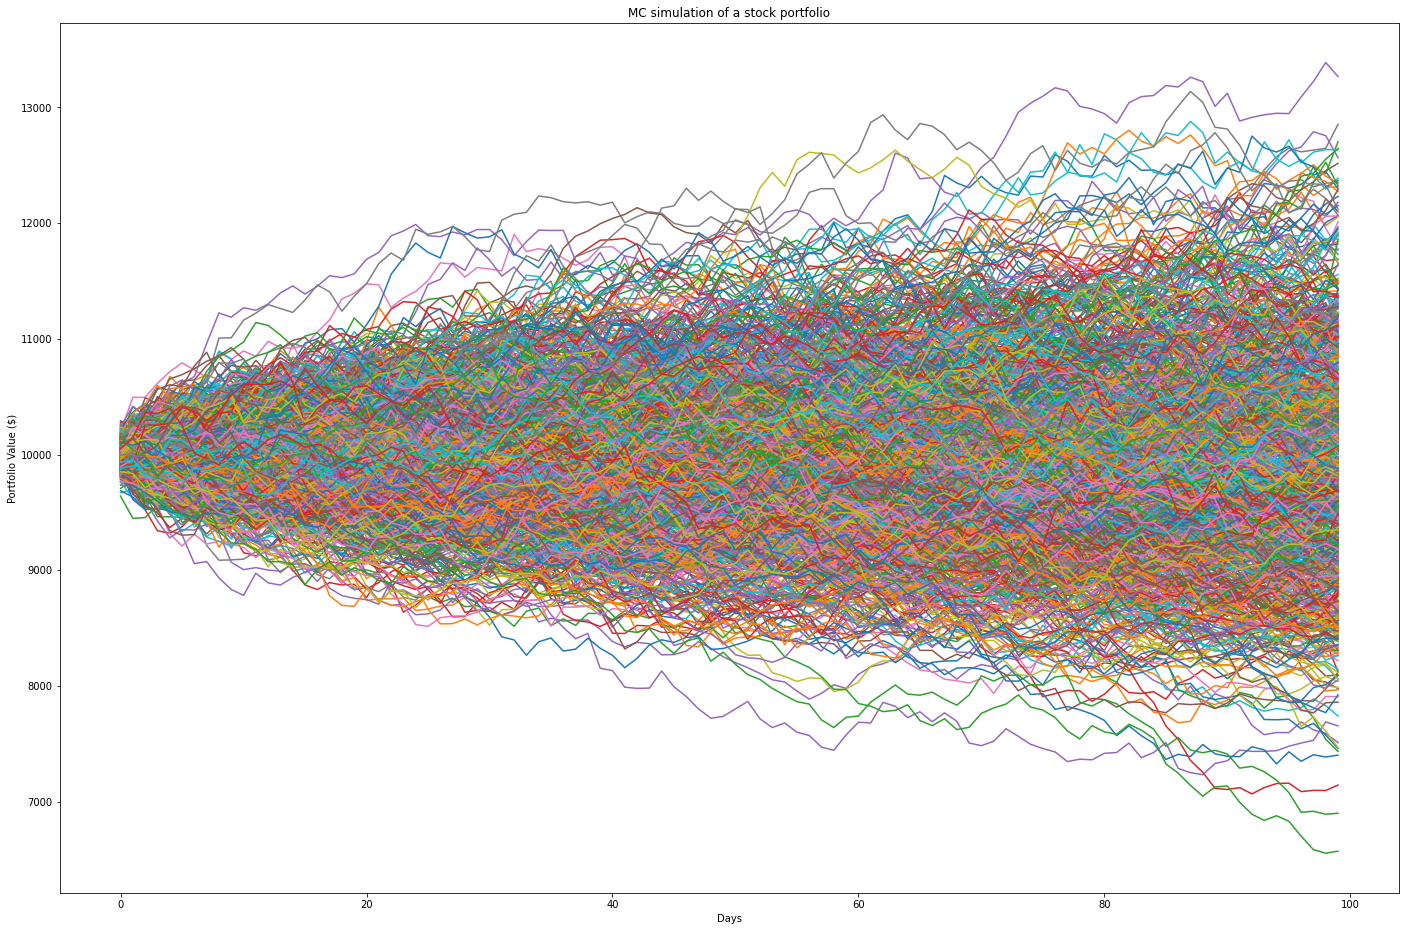

In [ ]:
for m in range(0, mc_sims):
  # MC loops
  Z = np.random.normal(size = (T, len(weights)))
  L = np.linalg.cholesky(covMatrix) #???????
  dailyReturns = meanM + np.inner(L, Z) #????????
  portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*InitialPortfolio # add 1 since we have daily change here

plt.figure(figsize = (24,16))
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()


1.   What level of certainty to a percentile of this distribution?
2.   What the VaR is?
3.   Past that defined CI, we want to know what the expected shortfall is or the CVaR?



### MC VaR & CVaR

In [ ]:
def mcVaR(returns, alpha=5):
  """ Input: pandas series of returns
      Output: percentile on returns distribution to a given confidence level alpha
  """
  if isinstance(returns, pd.Series):
    return np.percentile(returns, alpha)
  else:
    raise TypeError('Expected a panda data series.')

In [ ]:
def mcCVaR(returns, alpha=5):
  """ Input: pandas series of returns
      Output: CVaR / expected shortfall to a given confidence level alpha
  """
  if isinstance(returns, pd.Series):
    belowVaR = returns <= mcVaR(returns, alpha =alpha)
    return returns[belowVaR].mean()
  else:
    raise TypeError('Expected a panda data series.')

In [ ]:
portResults = pd.Series(portfolio_sims[-1,:]) # slice to the end of the time period, it could be changed at any point you want to analyze.

In [ ]:
VaR_1 = InitialPortfolio - mcVaR(portResults, alpha=5)
CVaR_1 = InitialPortfolio - mcCVaR(portResults, alpha=5)

In [ ]:
print('VaR ${}'.format(round(VaR_1, 2)))
print('CVaR ${}'.format(round(CVaR_1, 2)))

VaR $1559.57
CVaR $1955.99
